# Import

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"#使用第一块GPU（从0开始）
import cv2
import time
import json

from help_functions import *
from pre_processing import my_PreProc
from extract_patches import get_data_training, recompone, recompone_overlap, paint_border, kill_border, pred_only_FOV, get_data_testing, get_data_testing_overlap
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Multiply,Add, Concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, concatenate, UpSampling2D, Conv2DTranspose, AveragePooling2D, SeparableConv2D
from tensorflow.python.keras.regularizers import l2
from tensorflow.python.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import  ModelCheckpoint,LearningRateScheduler,EarlyStopping,Callback
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score

%matplotlib inline  

import numpy as np
import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.backend as K
import tensorflow.keras.layers as KL
import pandas as pd

np.random.seed(1)

# Data Processing

In [2]:
!nvidia-smi

Mon Mar 11 22:39:57 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.24.02    Driver Version: 465.24.02    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 42%   45C    P8    27W / 260W |      1MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:68:00.0  On |                  N/A |
| 37%   

In [11]:
#dataset path
dataset_path_test = "./DRHAGIS/test/"
dataset_path_train = "./DRHAGIS/train/"

#train dataset path
original_imgs_train = dataset_path_train + "DRHAGIS_dataset_imgs_train_1.hdf5"
groundTruth_imgs_train = dataset_path_train + "DRHAGIS_dataset_groundTruth_train_1.hdf5"
borderMasks_imgs_train = dataset_path_train + "DRHAGIS_dataset_borderMasks_train_1.hdf5"

#test dataset path
original_imgs_test = dataset_path_test + "DRHAGIS_dataset_imgs_test_1.hdf5"
groundTruth_imgs_test = dataset_path_test + "DRHAGIS_dataset_groundTruth_test_1.hdf5"
borderMasks_imgs_test = dataset_path_test + "DRHAGIS_dataset_borderMasks_test_1.hdf5"

patch_height, patch_width = 64, 64
stride_height, stride_width = 32,32
tr_nums = 38025

#load the training data and divided in patches
patches_imgs_train, patches_masks_train = get_data_training(
    train_imgs_original=original_imgs_train,
    train_groudTruth=groundTruth_imgs_train,
    patch_height=patch_height,
    patch_width=patch_width,
    N_subimgs=tr_nums,
    inside_FOV = False,
    dataset_type='DRHAGIS_1'
)

patches_imgs_train = np.transpose(patches_imgs_train, (0, 2, 3, 1))
patches_masks_train = np.transpose(patches_masks_train, (0, 2, 3, 1))
print(patches_masks_train.shape, patches_imgs_train.shape, np.max(patches_masks_train))
#tr_data, tr_mask = patches_imgs_train.astype(np.float32), patches_masks_train.astype(np.float32)
tr_data, tr_mask = patches_imgs_train.astype(np.float32), np.round(patches_masks_train).astype(np.float32)

#load the testing data and divide in patches
patches_imgs_test, new_height, new_width, masks_test = get_data_testing_overlap(
    test_imgs_original = original_imgs_test,
    test_groudTruth = groundTruth_imgs_test,
    Imgs_to_test = 2,
    patch_height = patch_height,
    patch_width = patch_width,
    stride_height = stride_height,
    stride_width = stride_width
)

patches_imgs_test = np.transpose(patches_imgs_test,(0, 2, 3, 1))
masks_test = np.transpose(masks_test,(0, 2, 3, 1))
#te_data,te_mask = patches_imgs_test.astype(np.float32), masks_test.astype(np.float32)
te_data, te_mask = patches_imgs_test.astype(np.float32), np.round(masks_test).astype(np.float32)
print(tr_data.shape,tr_mask.shape,te_data.shape,te_mask.shape)

#save training and testing data
np.save('./DRHAGIS-dataset/DRHAGIS-1/tr_data_patch.npy', tr_data)
np.save('./DRHAGIS-dataset/DRHAGIS-1/tr_mask_patch.npy', tr_mask)
np.save('./DRHAGIS-dataset/DRHAGIS-1/te_data_patch.npy', te_data)
np.save('./DRHAGIS-dataset/DRHAGIS-1/te_mask_patch.npy', te_mask)
print('saved')


train images/masks shape:
(9, 1, 3168, 3168)
train images range (min-max): 0.01568627450980392 - 0.984313725490196
train masks are within 0-1

patches per full image: 4225

train PATCHES images/masks shape:
(38025, 1, 64, 64)
train PATCHES images range (min-max): 0.01568627450980392 - 0.984313725490196
(38025, 64, 64, 1) (38025, 64, 64, 1) 1.0
the side W is not compatible with the selected stride of 32
img_w 4752, patch_w 64, stride_w 32
(img_w - patch_w) MOD stride_w: 16
So the W dim will be padded with additional 16 pixels
new full images shape: 
(2, 1, 3168, 4768)

test images shape:
(2, 1, 3168, 4768)

test mask shape:
(2, 1, 3168, 4752)
test images range (min-max): 0.0 - 1.0
test masks are within 0-1

Number of patches on h : 98
Number of patches on w : 148
number of patches per image: 14504, totally for this dataset: 29008

test PATCHES images shape:
(29008, 1, 64, 64)
test PATCHES images range (min-max): 0.0 - 1.0
(38025, 64, 64, 1) (38025, 64, 64, 1) (29008, 64, 64, 1) (2, 316

# Loss Function

In [4]:
def FL(y_true,y_pred):
    return focal_loss(y_true,y_pred)

def focal_loss(y, pred, alpha=0.8, gamma=2.):
        r"""Compute focal loss for predictions.
            Multi-labels Focal loss formula:
                FL = -alpha * (z-p)^gamma * log(p) -(1-alpha) * p^gamma * log(1-p)
                     ,which alpha = 0.25, gamma = 2, p = sigmoid(x), z = target_tensor.
        Args:
         pred: A float tensor of shape [batch_size, num_anchors,
            num_classes] representing the predicted logits for each class
         y: A float tensor of shape [batch_size, num_anchors,
            num_classes] representing one-hot encoded classification targets
         alpha: A scalar tensor for focal loss alpha hyper-parameter
         gamma: A scalar tensor for focal loss gamma hyper-parameter
        Returns:
            loss: A (scalar) tensor representing the value of the loss function
        """
        zeros = tf.zeros_like(pred, dtype=pred.dtype)

        # For positive prediction, only need consider front part loss, back part is 0;
        # target_tensor > zeros <=> z=1, so positive coefficient = z - p.
        pos_p_sub = tf.where(y > zeros, y - pred, zeros) # positive sample 寻找正样本，并进行填充

        # For negative prediction, only need consider back part loss, front part is 0;
        # target_tensor > zeros <=> z=1, so negative coefficient = 0.
        neg_p_sub = tf.where(y > zeros, zeros, pred) # negative sample 寻找负样本，并进行填充
        per_entry_cross_ent = - alpha * (pos_p_sub ** gamma) * tf.math.log(tf.clip_by_value(pred, 1e-8, 1.0)) \
                              - (1 - alpha) * (neg_p_sub ** gamma) * tf.math.log(tf.clip_by_value(1.0 - pred, 1e-8, 1.0))

        return tf.reduce_mean(per_entry_cross_ent)

def dice_loss(y_true, y_pred):
    smooth = 1. # 用于防止分母为0.
    y_true_f = K.flatten(y_true) # 将 y_true 拉伸为一维.
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f * y_true_f) + K.sum(y_pred_f * y_pred_f) + smooth)

def df_loss(y_true, y_pred):
    return 1*dice_loss(y_true, y_pred) + 0.8 * focal_loss(y_true, y_pred)

def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard
# --------------------------- BINARY LOSSES ---------------------------
def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss

def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """
    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   # strict=True,
                   name="loss"
                   )
    return loss
def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels

# Evaluating and showing

In [12]:
test_imgs_orig = load_hdf5(original_imgs_test)
test_imgs_truth = load_hdf5(groundTruth_imgs_test)
test_border_masks = load_hdf5(borderMasks_imgs_test)

def evaluate(model_name):
    full_img_height = test_imgs_orig.shape[2]
    full_img_width = test_imgs_orig.shape[3]
    test_border_masks = load_hdf5(borderMasks_imgs_test)
    N_visual = 1
    
    # get predictions
    model.load_weights(model_name, by_name=True)
    predictions = model.predict(te_data, verbose=2) #batch_size=1,
    predictions = predictions[3]
    # re-component to full size
    predictions = np.transpose(predictions,(0,3,1,2))
    predictions = recompone_overlap(predictions, new_height, new_width, stride_height, stride_width)# predictions
    gtruth_masks = np.transpose(te_mask,(0,3,1,2))
    
    # back to original dimensions
    predictions = predictions[:, :, 0:full_img_height, 0:full_img_width]
    pred_imgs = predictions
    orig_imgs = my_PreProc(test_imgs_orig[0:pred_imgs.shape[0], :, :, :])
    shape = predictions.shape
    
    def dice_score(y_true, y_pred):
        # y = K.round(K.flatten(y_pred))#tf.one_hot(pred_max,depth=num_classes)
        # x = K.round(K.flatten(y_true))
        y_pred = y_pred[:,:,0:full_img_height,0:full_img_width]
        p = y_pred.flatten()#tf.one_hot(pred_max,depth=num_classes)
        t = y_true.flatten()
        p,t = np.round(p),np.round(t)
        intersection = np.sum(p * t)
        union = np.sum(p) + np.sum(t)- intersection
        dice = (2*intersection+0.001) /  (union+intersection+0.001)
        return np.mean(dice)
    print('dice:', dice_score(gtruth_masks,pred_imgs))
    # apply the DRIVE masks on the repdictions #set everything outside the FOV to zero!!
    kill_border(pred_imgs, test_border_masks)  #DRIVE MASK  #only for visualization
    print("Orig imgs shape: " +str(orig_imgs.shape))
    print("pred imgs shape: " +str(pred_imgs.shape))
    print("Gtruth imgs shape: " +str(gtruth_masks.shape))
    visualize(group_images(orig_imgs,N_visual), "all_originals")#.show()
    visualize(group_images(pred_imgs,N_visual), "all_predictions")#.show()
    visualize(group_images(gtruth_masks,N_visual), "all_groundTruths")#.show()
    #visualize results comparing mask and prediction:
    assert (orig_imgs.shape[0]==pred_imgs.shape[0] and orig_imgs.shape[0]==gtruth_masks.shape[0])
    N_predicted = orig_imgs.shape[0]
    group = N_visual
    assert (N_predicted%group==0)
    for i in range(int(N_predicted/group)):
        orig_stripe = group_images(orig_imgs[i*group:(i*group)+group,:,:,:],group)
        masks_stripe = group_images(gtruth_masks[i*group:(i*group)+group,:,:,:],group)
        pred_stripe = group_images(pred_imgs[i*group:(i*group)+group,:,:,:],group)
        total_img = np.concatenate((orig_stripe,masks_stripe,pred_stripe),axis=0)
        visualize(total_img,"Original_GroundTruth_Prediction"+str(i))#.show()
        
    #====== Evaluate the results
    print("\n\n========  Evaluate the results =======================")
    #predictions only inside the FOV
    y_scores, y_true = pred_only_FOV(pred_imgs, gtruth_masks, test_border_masks)  #returns data only inside the FOV
    #y_true = (np.round(y_true)).astype(np.int32)
    print("Calculating results only inside the FOV:")
    print("y scores pixels: " +str(y_scores.shape[0]) +" (radius 270: 270*270*3.14==228906), including background around retina: " +str(pred_imgs.shape[0]*pred_imgs.shape[2]*pred_imgs.shape[3]) +" (584*565==329960)")
    print("y true pixels: " +str(y_true.shape[0]) +" (radius 270: 270*270*3.14==228906), including background around retina: " +str(gtruth_masks.shape[2]*gtruth_masks.shape[3]*gtruth_masks.shape[0])+" (584*565==329960)")
    
    #Area under the ROC curve
    fpr, tpr, thresholds = roc_curve((y_true), y_scores)
    AUC_ROC = roc_auc_score(y_true, y_scores)
    # test_integral = np.trapz(tpr,fpr) #trapz is numpy integration
    print("\nArea under the ROC curve: " +str(AUC_ROC))
    roc_curve_f =plt.figure()
    plt.plot(fpr,tpr,'-',color='darkorange',lw=2,label='Area Under the Curve (AUC = %0.4f)' % AUC_ROC)
    plt.plot([0,1],[0,1],color='navy',linestyle='--',lw=2)
    plt.title('ROC curve')
    plt.xlim([0.,1.])
    plt.ylim([0.,1.005])
#     plt.plot(fpr,tpr,'-',label='Area Under the Curve (AUC = %0.4f)' % AUC_ROC)
#     plt.title('ROC curve')
    plt.xlabel("FPR (False Positive Rate)")
    plt.ylabel("TPR (True Positive Rate)")
    plt.legend(loc="lower right")
    plt.savefig("ROC.png")
    plt.show()
    
    ############################################################################
    #记录fpr、tpr
    # save_path = './csv_results/' + model_name.split('/')[2].split('.')[0] + '_fpr_tpr.csv'
    save_path = './csv_results/' + model_name.split('.')[0] + '_fpr_tpr.csv'
    df = pd.DataFrame.from_dict({'fpr': fpr, 'tpr': tpr})
    df.to_csv(save_path)
    print('ROC曲线的.csv文件已保存到' + save_path)
    ############################################################################
        
    #Precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    precision = np.fliplr([precision])[0]  #so the array is increasing (you won't get negative AUC)
    recall = np.fliplr([recall])[0]  #so the array is increasing (you won't get negative AUC)
    AUC_prec_rec = np.trapz(precision,recall)
    
    ############################################################################
    #记录recall、precision
    # save_path = './csv_results/'+ model_name.split('/')[2].split('.')[0] +'_precision_recall.csv'
    save_path = './csv_results/' + model_name.split('.')[0] + '_precision_recall.csv'
    df = pd.DataFrame.from_dict({'precision': precision, 'recall': recall})
    df.to_csv(save_path)
    print('PR曲线的.csv文件已保存到' + save_path)
    ############################################################################
    
    print("\nArea under Precision-Recall curve: " +str(AUC_prec_rec))
    prec_rec_curve = plt.figure()
    plt.plot(recall,precision,'-',lw=2,color='darkorange',label='Area Under the Curve (AUC = %0.4f)' % AUC_prec_rec)
    plt.plot([1,0],[0,1],color='navy',linestyle='--',lw=2)
    plt.xlim([0.,1.])
    plt.ylim([0.,1.005])
#     plt.plot(recall,precision,'-',label='Area Under the Curve (AUC = %0.4f)' % AUC_prec_rec)
#     plt.title('Precision - Recall curve')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="lower right")
    plt.savefig("Precision_recall.png")
    plt.show()
    #Confusion matrix
    threshold_confusion = 0.5
    print("\nConfusion matrix:  Custom threshold (for positive) of " +str(threshold_confusion))
    y_pred = np.empty((y_scores.shape[0]))
    for i in range(y_scores.shape[0]):
        if y_scores[i]>=threshold_confusion:
            y_pred[i]=1
        else:
            y_pred[i]=0
    confusion = confusion_matrix(y_true, y_pred)
    print(confusion)
    accuracy = 0
    if float(np.sum(confusion))!=0:
        accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
    print("Global Accuracy: " +str(accuracy))
    specificity = 0
    if float(confusion[0,0]+confusion[0,1])!=0:
        specificity = float(confusion[0,0])/float(confusion[0,0]+confusion[0,1])
    print("Specificity: " +str(specificity))
    sensitivity = 0
    if float(confusion[1,1]+confusion[1,0])!=0:
        sensitivity = float(confusion[1,1])/float(confusion[1,1]+confusion[1,0])
    print("Sensitivity: " +str(sensitivity))
    precision = 0
    if float(confusion[1,1]+confusion[0,1])!=0:
        precision = float(confusion[1,1])/float(confusion[1,1]+confusion[0,1])
    print("Precision: " +str(precision))

    # #Jaccard Jaccard similarity coefficient score
    # jaccard = jaccard_score(y_true, y_pred)
    # print("\nJaccard : " +str(jaccard))

    # jaccard_score(y_true, y_pred)
    #Jaccard similarity index
    jaccard_index = jaccard_similarity_score(y_true, y_pred, normalize=True)
    print("\nJaccard similarity score: " +str(jaccard_index))

    #F1 score
    F1_score = f1_score(y_true, y_pred, labels=None, average='binary', sample_weight=None)
    print("\nF1 score (F-measure): " +str(F1_score))

    #Save the results
#     file_perf = open('performances.txt', 'w')
    # file_perf = open('./performance_results/'+ model_name.split('/')[2].split('.')[0] +'_performances.txt', 'w')
    file_perf = open('./performance_results/' + model_name.split('.')[0] + '_performances.txt', 'w')
    file_perf.write("Area under the ROC curve: "+str(AUC_ROC)
                    + "\nArea under Precision-Recall curve: " +str(AUC_prec_rec)
                    + "\nJaccard similarity score: " +str(jaccard_index)
                    + "\nF1 score (F-measure): " +str(F1_score)
                    +"\n\nConfusion matrix:"
                    +str(confusion)
                    +"\nACCURACY: " +str(accuracy)
                    +"\nSENSITIVITY: " +str(sensitivity)
                    +"\nSPECIFICITY: " +str(specificity)
                    +"\nPRECISION: " +str(precision)
                    )
    file_perf.close()
    # print(model_name.split('/')[2].split('.')[0]+'的性能文件已保存到'+'./performance_results/'+ model_name.split('/')[2].split('.')[0] +'_performances.txt')
    print(model_name.split('.')[0]+'的性能文件已保存到'+'./performance_results/'+ model_name.split('.')[0] +'_performances.txt')
    
def show_result(items=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]): #0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
    dice_out = 0
    print("="*50)
    print("红色是预测结果缺少的，蓝色是多出来的")
    print("="*50)
    for i in items:#range(20):
        img = plt.imread('Original_GroundTruth_Prediction{}.png'.format(i))
        #img_ori = img[:960,:]
#         test_imgs_orig = load_hdf5(original_imgs_test)
        # print(test_imgs_orig)
        img_ori = np.transpose(test_imgs_orig[i,:,:,:],(1,2,0))/255.
        img = np.round(img)
        img_mask = img[584:1168,:]
        img = img[1168:,:]
        plt.figure(figsize=(20,20))
        plt.subplot(221)
        plt.imshow(img_mask,'gray')
        # plt.subplot(222)
        # plt.imshow(img,'gray')
        # plt.show()
        # print(img.shape,img.shape[0]/3.*2)
        # img = cv2.erode(img,np.ones((2,2)))
        # img = cv2.dilate(img,np.ones((2,2)))
        # https://blog.csdn.net/qq_30490125/article/details/80490776 开闭操作  cv2.MORPH_OPEN  cv2.MORPH_CLOSE
        # retval=cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
        # # 核的形状，有cv2.MORPH_RECT , cv2.MORPH_CROSS和cv2.MORPH_ELLIPSE 
        # img = cv2.morphologyEx(img,cv2.MORPH_CLOSE,retval)
        # img = cv2.morphologyEx(img,cv2.MORPH_OPEN,retval)
        plt.subplot(222)
        plt.imshow(img_ori)
        plt.subplot(223)
        plt.imshow(img, 'gray')
        plt.subplot(224)
        #img_result = img_ori
        #img_result = img
        img_result = np.stack([img]*3,axis=-1)
        #img_result = np.stack([img_ori]*3,axis=-1)
        img_result[:,:,0]=np.where(img<img_mask,1.,img_result[:,:,0])        
        img_result[:,:,1]=np.where(img<img_mask,0.,img_result[:,:,1])
        img_result[:,:,2]=np.where(img<img_mask,0.,img_result[:,:,2])
        #############红色是预测结果缺少的，蓝色是多出来的
        img_result[:,:,0]=np.where(img>img_mask,0.,img_result[:,:,0])
        img_result[:,:,1]=np.where(img>img_mask,0.,img_result[:,:,1])
        img_result[:,:,2]=np.where(img>img_mask,1.,img_result[:,:,2])
        
        plt.imshow(img_result)
        plt.tight_layout()
        iou = (np.sum(np.where(img + img_mask == 2, 1, 0))) / (np.sum((np.where(img + img_mask, 1, 0))))
        # dice = (2*jaccard)/(1+jaccard)   jaccard=dice/(2-dice)
        print(i, iou, 2 * iou / (1 + iou))
        dice_out += (2 * iou / (1 + iou)) #2,5,7,17,6,8,9,10,14,15
        plt.title('Dice:{}'.format(2 * iou / (1 + iou)))
        plt.show()

# Defining blocks

In [6]:
init = tf.keras.initializers.glorot_uniform(seed=1)

#------------------------------------------------fsf block------------------------------------------------
def se_net(x, r=4):
    input_channel = x.shape[-1]
    outputs = KL.GlobalMaxPooling2D()(x)
    outputs = KL.Reshape((1, 1, input_channel))(outputs)
    outputs = Dense(input_channel // r)(outputs)
    outputs = Activation('relu')(outputs)
    outputs = Dense(input_channel)(outputs)
    outputs = Activation('sigmoid')(outputs)
    outputs = KL.Multiply()([x, outputs])
    return outputs

def fsf_block(low_x, high_x):
    outputs = concatenate([high_x, low_x], axis=3)
    outputs = se_net(outputs)
    outputs = Conv2D(kernel_size=(1, 1), filters=int(outputs.shape[-1] / 2), strides=1, padding='same')(outputs)
    outputs = KL.GlobalMaxPooling2D()(outputs)
    outputs = KL.Reshape((1, 1, outputs.shape[-1]))(outputs)
    outputs = Activation('sigmoid')(outputs)
    outputs = KL.Multiply()([low_x, outputs])
    outputs = KL.add([outputs, high_x])
    return outputs
#------------------------------------------------fsf block------------------------------------------------

#------------------------------------------------sal block------------------------------------------------
def SAL(x, filters, size):
    x = Conv2D(kernel_size=size, filters=filters, strides=1, padding='same', use_bias=False, kernel_initializer=init, activation='relu')(x)
    outputs = Conv2D(kernel_size=size, filters=filters, strides=1, padding='same', use_bias=False, kernel_initializer=init)(x)
    outputs = BatchNormalization()(outputs)
    outputs = Dropout(0.5)(outputs)
    outputs = Activation('relu')(outputs)
    outputs = Conv2D(kernel_size=size, filters=filters, strides=1, padding='same', use_bias=False, kernel_initializer=init)(outputs)
    outputs = BatchNormalization()(outputs)
    outputs = KL.add([outputs, x])
    outputs = Activation('relu')(outputs)
    return outputs
#------------------------------------------------sal block------------------------------------------------

#------------------------------------------------ar path------------------------------------------------
def ar_path(x, filters, size):
    outputs = Conv2D(kernel_size=size, filters=filters, strides=1, dilation_rate=(2, 2), padding='same', use_bias=False, kernel_initializer=init)(x)
    outputs = BatchNormalization()(outputs)
    x = Conv2D(kernel_size=(1, 1), filters=filters, strides=1, padding='same')(x)
    outputs = KL.add([outputs, x])
    outputs = Activation('relu')(outputs)
    return outputs
#------------------------------------------------ar path------------------------------------------------

# Modified Unet module

In [7]:
def SADS_Unet(img_rows, img_cols, channels=1, num_class=1, DropoutRatio=0):
    num_f = [32,64,128,256,512,1024]
    inputs = Input((img_rows, img_cols, channels))
    
    #encoder
    conv1_0 = SAL(inputs, num_f[0], (3, 3))
    
    maxpooling = MaxPooling2D()(conv1_0)
    
    conv2_0 = SAL(maxpooling, num_f[1], (3, 3))
    
    maxpooling = MaxPooling2D()(conv2_0)
    
    conv3_0 = SAL(maxpooling, num_f[2], (3, 3))
    
    maxpooling = MaxPooling2D()(conv3_0)
    
    conv4_0 = SAL(maxpooling, num_f[3], (3, 3))
    
    maxpooling = MaxPooling2D()(conv4_0)
    
    conv5_0 = SAL(maxpooling, num_f[4], (3, 3))
    
    #decoder
    conv4_1 = ar_path(conv4_0, num_f[4], (3, 3))
    fusion = fsf_block(conv4_1, UpSampling2D()(conv5_0))
    conv4_2 = SAL(fusion, num_f[3], (3, 3))
    
    conv3_1 = ar_path(conv3_0, num_f[3], (3, 3))
    fusion = fsf_block(conv3_1, UpSampling2D()(conv4_2))
    conv3_2 = SAL(fusion, num_f[2], (3, 3))
    
    conv2_1 = ar_path(conv2_0, num_f[2], (3, 3))
    fusion = fsf_block(conv2_1, UpSampling2D()(conv3_2))
    conv2_2 = SAL(fusion, num_f[1], (3, 3))
    
    conv1_1 = ar_path(conv1_0, num_f[1], (3, 3))
    fusion = fsf_block(conv1_1, UpSampling2D()(conv2_2))
    conv1_2 = SAL(fusion, num_f[0], (3, 3))
    
#------------------------------------------------mds block------------------------------------------------
    sup_3 = UpSampling2D()(conv4_2)
    sup_3 = UpSampling2D()(sup_3)
    sup_3 = UpSampling2D()(sup_3)
    sup_3 = Conv2D(kernel_size=(1, 1), filters=num_class, strides=1, padding='same', activation='sigmoid')(sup_3)
    
    sup_2 = UpSampling2D()(conv3_2)
    sup_2 = UpSampling2D()(sup_2)
    sup_2 = Conv2D(kernel_size=(1, 1), filters=num_class, strides=1, padding='same', activation='sigmoid')(sup_2)
    
    sup_1 = UpSampling2D()(conv2_2)
    sup_1 = Conv2D(kernel_size=(1, 1), filters=num_class, strides=1, padding='same', activation='sigmoid')(sup_1)
    
    outputs = Conv2D(kernel_size=(1, 1), filters=num_class, strides=1, padding='same', activation='sigmoid')(conv1_2)
    
#------------------------------------------------mds block------------------------------------------------

    model = Model(inputs=[inputs], outputs=[sup_3, sup_2, sup_1, outputs])  
    return model

# Training

In [8]:
class LossHistory(Callback):
    def __init__(self,model, model_name, **kwargs):
    # self.output_dim = output_dim
        super(LossHistory, self).__init__(**kwargs)
        self.model = model
        self.model_name = model_name
        self.best_val_dice=0
        self.record_dict = []
        self.loss,self.pr,self.re,self.F,self.dice,self.acc= [],[],[],[],[],[]
        with open(self.model_name[:-3]+'.json', 'w') as fp:  #清空文件
            fp.write('')
    def on_epoch_end(self, epoch, logs={}):
        epoch_metric = dict()
        for meric_name in ['loss','pr','re','F','dice','acc']:
            epoch_metric[meric_name] = float(logs.get(meric_name)) #转换为python的浮点
            epoch_metric['val_'+meric_name] = float(logs.get('val_'+meric_name)) #转换为python的浮点
        #字典json自动排序F, acc, dice, loss, pr, re
        with open(self.model_name[:-3]+'.json', 'a') as fp:
            json.dump({epoch:epoch_metric}, fp, indent=4, sort_keys=True)
        val_dice = logs.get('val_dice')
        if val_dice>self.best_val_dice:
            self.best_val_dice = val_dice
            print('\nupdate best_val_dice:',self.best_val_dice)
            self.model.save_weights(self.model_name)

In [9]:
def re(y_true, y_pred):
    p = K.round(K.flatten(y_pred))#K.flatten(y_pred)
    t = K.flatten(y_true)
    t_mask = tf.equal(t,1.0)
    p_mask = tf.boolean_mask(p,t_mask,name='t_mask')
    re = K.sum(p_mask)/(K.sum(t)+10e-6)
    return K.mean(re)
  # return tf.keras.metrics.precision(y_true, y_pred)
def pr(y_true, y_pred):
    p = K.round(K.flatten(y_pred))#K.flatten(1.-y_pred)
    t = K.flatten(y_true)
    t_mask = tf.equal(t,1.)
    p_mask = tf.boolean_mask(p,t_mask,name='t_mask')
    pr = K.sum(p_mask)/(K.sum(p)+10e-6)
    return K.mean(pr)
  # return tf.keras.metrics.recall(y_true, y_pred)
def F(y_true, y_pred):
    return 2./(1./pr(y_true,y_pred)+1./re(y_true,y_pred))
def m(y_true, y_pred):
    return tf.keras.metrics.mean_iou(y_true,y_pred,num_classes=1)
def dice(y_true, y_pred):
    p = K.flatten(y_pred)#tf.one_hot(pred_max,depth=num_classes)
    t = K.flatten(y_true)
    p,t = K.round(p),K.round(t)
    intersection = K.sum(p * t)
    union = K.sum(p) + K.sum(t)- intersection
    dice = (2*intersection+0.001) /  (union+intersection+0.001)
    return K.mean(dice)
def LSL(y_true, y_pred):
    y_pred_bc = y_pred
    y_pred = 2. * y_pred - 1.
    y_true_bc  = y_true 
    return 0.9*lovasz_hinge(logits=y_pred,labels=y_true,ignore=None,per_image=True) +  0.1*binary_crossentropy(y_true_bc,y_pred_bc)

In [14]:
my_loss = [dice_loss, dice_loss, dice_loss, dice_loss]
my_weights = [1, 1, 4, 10]
def train(model, model_name, losshistory, loss=my_loss, loss_weights=my_weights):
    start = time.time()
    print(time.strftime('%H:%M:%S', time.localtime((time.time()))))
    earlystop_callback = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=20)
    for i in range(1):
        d = np.math.pow(10, i)
        sgd = optimizers.SGD(lr=0.005/d, decay=1e-3/d, momentum=0.9, nesterov=True)
        model.compile(loss=loss, loss_weights=loss_weights, optimizer=sgd, metrics=[pr,re,F,dice,'acc'])
        if(i != 0): model.load_weights(model_name)
        #model.fit(tr_data, tr_mask, epochs=int(15 / (i + 1)), batch_size=8, verbose=1, shuffle=True,
        #          validation_split=0.3, callbacks=[losshistory, earlystop_callback])
        model.fit(tr_data, tr_mask, epochs=15, batch_size=8, verbose=1, shuffle=True)
    time_cost = time.time() - start
    print('time cost: {:.0f}h {:.0f}m {:.0f}s'.format(time_cost // 3600, (time_cost % 3600) // 60, time_cost % 60))
    #model.load_weights(model_name)
    model.save_weights(model_name)
    #model.summary()

In [15]:
data_shape = tr_data.shape
model = SADS_Unet(img_rows=data_shape[1], img_cols=data_shape[2], channels=data_shape[3])
model_name = 'SADS_Unet.h5'
losshistory = LossHistory(model, model_name=model_name)
train(model, model_name, losshistory)

19:22:19
Epoch 1/15
4754/4754 [==============================] - 180s 38ms/step - loss: 11.5887 - conv2d_82_loss: 0.6977 - conv2d_83_loss: 0.6768 - conv2d_84_loss: 0.7292 - conv2d_85_loss: 0.7298 - conv2d_82_pr: 0.2023 - conv2d_82_re: 0.2256 - conv2d_82_F: 0.1881 - conv2d_82_dice: 0.1992 - conv2d_82_acc: 0.9377 - conv2d_83_pr: 0.2505 - conv2d_83_re: 0.2699 - conv2d_83_F: 0.2234 - conv2d_83_dice: 0.2303 - conv2d_83_acc: 0.9350 - conv2d_84_pr: 0.2088 - conv2d_84_re: 0.4260 - conv2d_84_F: 0.2042 - conv2d_84_dice: 0.2086 - conv2d_84_acc: 0.7648 - conv2d_85_pr: 0.2310 - conv2d_85_re: 0.5309 - conv2d_85_F: 0.2186 - conv2d_85_dice: 0.2199 - conv2d_85_acc: 0.6542
Epoch 2/15
4754/4754 [==============================] - 181s 38ms/step - loss: 8.2814 - conv2d_82_loss: 0.5514 - conv2d_83_loss: 0.5278 - conv2d_84_loss: 0.5182 - conv2d_85_loss: 0.5129 - conv2d_82_pr: 0.3959 - conv2d_82_re: 0.4517 - conv2d_82_F: 0.3934 - conv2d_82_dice: 0.3947 - conv2d_82_acc: 0.9480 - conv2d_83_pr: 0.4325 - conv2d_8

# Results showing

907/907 - 19s
N_patches_h: 98
N_patches_w: 148
N_patches_img: 14504
According to the dimension inserted, there are 2 full images (of 3168x4768 each)
(2, 1, 3168, 4768)
dice: 0.6904522149085197
Orig imgs shape: (2, 1, 3168, 4752)
pred imgs shape: (2, 1, 3168, 4752)
Gtruth imgs shape: (2, 1, 3168, 4752)


========  Evaluate the results =======================
Calculating results only inside the FOV:
y scores pixels: 13978442 (radius 270: 270*270*3.14==228906), including background around retina: 30108672 (584*565==329960)
y true pixels: 13978442 (radius 270: 270*270*3.14==228906), including background around retina: 30108672 (584*565==329960)

Area under the ROC curve: 0.9592738059667296


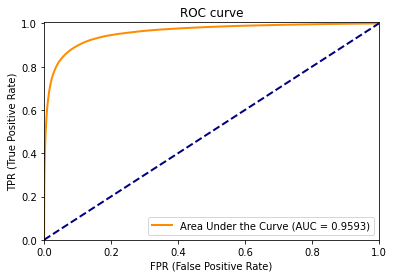

ROC曲线的.csv文件已保存到./csv_results/DRHAGIS-1_fpr_tpr.csv
PR曲线的.csv文件已保存到./csv_results/DRHAGIS-1_precision_recall.csv

Area under Precision-Recall curve: 0.791164857912352


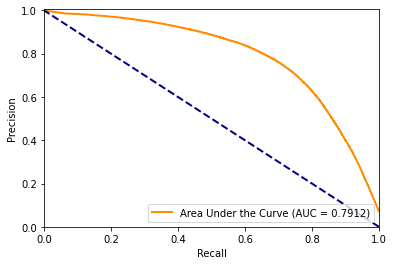


Confusion matrix:  Custom threshold (for positive) of 0.5
[[12785897   199887]
 [  310231   682427]]
Global Accuracy: 0.9635068056940823
Specificity: 0.9846072443527476
Sensitivity: 0.6874744373187945
Precision: 0.773451401655193

Jaccard similarity score: 0.9635068056940823

F1 score (F-measure): 0.7279330037995234
DRHAGIS-1的性能文件已保存到./performance_results/DRHAGIS-1_performances.txt
红色是预测结果缺少的，蓝色是多出来的


ValueError: operands could not be broadcast together with shapes (8336,4752) (584,4752) 

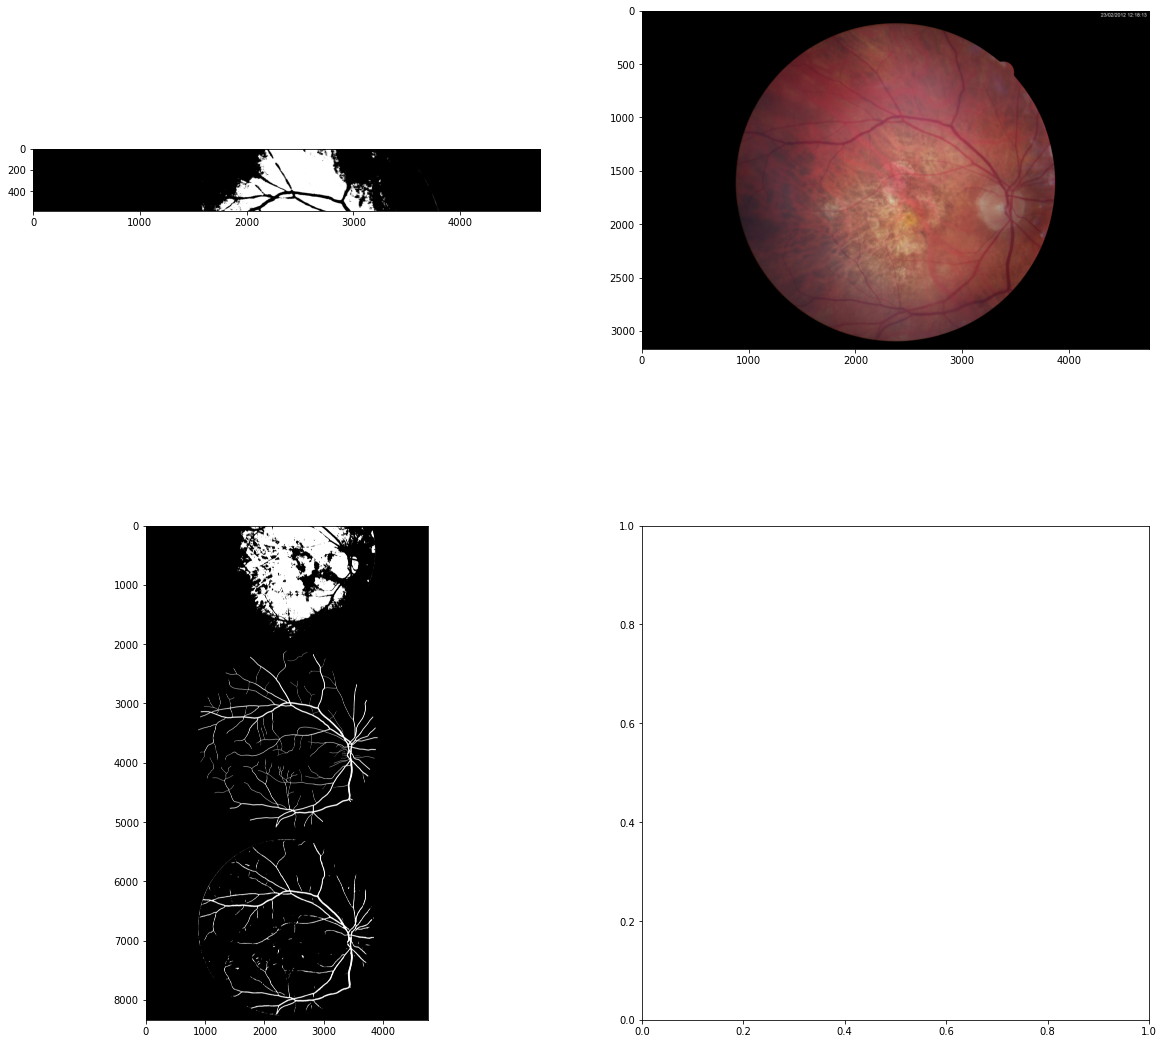

In [16]:
data_shape = tr_data.shape
model = SADS_Unet(img_rows=data_shape[1], img_cols=data_shape[2], channels=data_shape[3], num_class=1)
model_name = 'SADS_Unet.h5'
model.load_weights(model_name)
evaluate(model_name=model_name)
show_result()

# Last line